**Imports**

In [1]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.retro_data.consumption_data import get_demand
from functions.calculations.calculations import calculate_energy
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.rulebased import rule_based_energy_flow

**Definition des Green Energy Ecosystems**

In [2]:
# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 
longitude=4.208611 
azimuth=180 
albedo=0.2 

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # MWh
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # MWh
charging_rate = 10  # Lade-/Entladerate [MW/h]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

**Ausführen der Vorbereitungsfunktionen**

In [3]:
# Daten laden
df_weather = get_weather()
df_spot = get_spotprice()
df_demand = get_demand(num_houses, yearly_demand)
if df_weather is None or df_spot is None or df_demand is None:
    print("Abbruch.")

display(df_weather.head())
display(df_spot.head())
display(df_demand.head())

,datetime,solarradiation,windspeed,temp,cloudcover,humidity,sealevelpressure
0,2025-05-24 23:00:00,0.0,25.2,14.8,100.0,91.43,1011.0
1,2025-05-25 00:00:00,0.0,28.2,14.7,100.0,91.54,1010.8
2,2025-05-25 01:00:00,0.0,29.5,14.7,100.0,90.51,1010.7
3,2025-05-25 02:00:00,0.0,27.5,14.7,100.0,89.82,1010.4
4,2025-05-25 03:00:00,0.0,25.4,14.7,100.0,90.14,1009.7


,datetime,spotprice
0,2025-05-24 23:00:00,79.67
1,2025-05-25 00:00:00,23.82
2,2025-05-25 01:00:00,22.90
3,2025-05-25 02:00:00,14.39
4,2025-05-25 03:00:00,8.38


,datetime,energy_demand
0,2025-05-24 23:00:00,10.857744
1,2025-05-25 00:00:00,10.342031
2,2025-05-25 01:00:00,9.811669
3,2025-05-25 02:00:00,9.485302
4,2025-05-25 03:00:00,9.268449


**Ausführen der Berechnungsfunktion**

In [4]:
# Bedarf und Ertrag berechnen
df_energy = calculate_energy(
df_weather, 
solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)

display(df_energy.head())

,datetime,windspeed,poa_irradiance,solar_energy_production,wind_energy_production,total_energy_production
0,2025-05-24 23:00:00,25.2,0.0,0.0,2.957871,2.957871
1,2025-05-25 00:00:00,28.2,0.0,0.0,4.174387,4.174387
2,2025-05-25 01:00:00,29.5,0.0,0.0,4.850955,4.850955
3,2025-05-25 02:00:00,27.5,0.0,0.0,3.966791,3.966791
4,2025-05-25 03:00:00,25.4,0.0,0.0,3.106123,3.106123


**Datensätze mergen**

In [5]:
# Merge aller drei DataFrames
df_merged = df_energy.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
)

display(df_merged.head())

# Check auf NaN-Elemente
print("Anzahl NaN-Werte pro Spalte:")
print(df_merged.isna().sum())

,datetime,windspeed,poa_irradiance,solar_energy_production,wind_energy_production,total_energy_production,spotprice,energy_demand
0,2025-05-24 23:00:00,25.2,0.0,0.0,2.957871,2.957871,79.67,10.857744
1,2025-05-25 00:00:00,28.2,0.0,0.0,4.174387,4.174387,23.82,10.342031
2,2025-05-25 01:00:00,29.5,0.0,0.0,4.850955,4.850955,22.90,9.811669
3,2025-05-25 02:00:00,27.5,0.0,0.0,3.966791,3.966791,14.39,9.485302
4,2025-05-25 03:00:00,25.4,0.0,0.0,3.106123,3.106123,8.38,9.268449


Anzahl NaN-Werte pro Spalte:
datetime                   0
windspeed                  0
poa_irradiance             0
solar_energy_production    0
wind_energy_production     0
total_energy_production    0
spotprice                  0
energy_demand              0
dtype: int64


**Plot der Energiedaten und relevanten Wetterdaten der letzten 7 Tage**

C:\Users\Julian\AppData\Local\Temp\ipykernel_11880\3662034668.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_plot = df_merged.copy().set_index("datetime").last("7D")


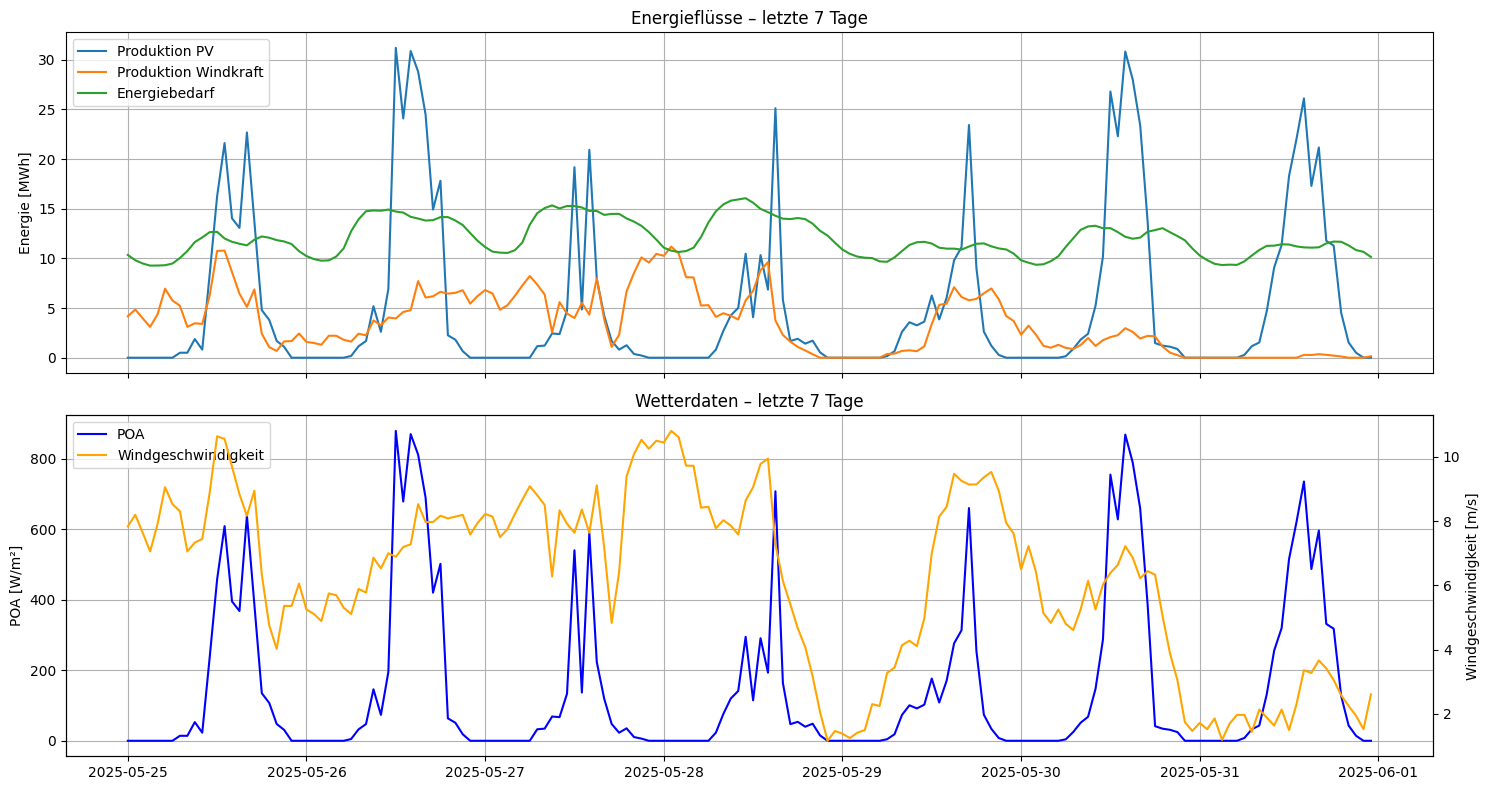

In [6]:
# Letzte 7 Tage extrahieren
df_plot = df_merged.copy().set_index("datetime").last("7D")

# Figure mit zwei Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Energieflüsse
ax1.plot(df_plot.index, df_plot["solar_energy_production"], label="Produktion PV")
ax1.plot(df_plot.index, df_plot["wind_energy_production"], label="Produktion Windkraft")
ax1.plot(df_plot.index, df_plot["energy_demand"], label="Energiebedarf")
ax1.set_ylabel("Energie [MWh]")
ax1.set_title("Energieflüsse – letzte 7 Tage")
ax1.legend()
ax1.grid(True)

# Wetterdaten
ax2a = ax2  # linke Achse
ax2b = ax2a.twinx()  # rechte Achse

line1, = ax2a.plot(df_plot.index, df_plot["poa_irradiance"], color="blue", label="POA")
line2, = ax2b.plot(df_plot.index, df_plot["windspeed"] / 3.6, color="orange", label="Windgeschwindigkeit")

ax2a.set_ylabel("POA [W/m²]")
ax2a.tick_params(axis='y')
ax2b.set_ylabel("Windgeschwindigkeit [m/s]")
ax2b.tick_params(axis='y')
ax2a.set_title("Wetterdaten – letzte 7 Tage")

# Gemeinsame Legende unten
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.grid(True)
ax2a.legend(lines, labels, loc="upper left")

plt.xlabel("Zeit")
plt.tight_layout()
plt.show()


**Ausführen der regelbasierten und optimierten Funktion**

In [7]:
# Optimierungsfunktionen
result_df_rule, result_kpis_rule = rule_based_energy_flow(
    df_merged, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )


result_df_opt, result_kpis_opt = optimize_energy_flow(
    df_merged, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor
    )

**Ausgabe der wichtigsten KPIs zum quanitiativen Vergleich der Performance**

In [8]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Export-gewichtete Preise
wavg_price_rule = (result_df_rule["spotprice_EUR_per_MWh"] * result_df_rule["ee_export_MWh"]).sum() / max(result_kpis_rule["Einspeisung"], 1e-9)
wavg_price_opt  = (result_df_opt["spotprice_EUR_per_MWh"]  * result_df_opt["ee_export_MWh"]).sum()  / max(result_kpis_opt["Einspeisung"], 1e-9)

# Tage aus Stunden
days = len(df_weather) / 24

# Basistabelle
summary = pd.DataFrame({
    "Netto Stromkosten gesamt [€]": [result_kpis_rule["Netto Stromkosten"], result_kpis_opt["Netto Stromkosten"]],
    "Netto Stromkosten/Tag [€/d]":  [result_kpis_rule["Netto Stromkosten"]/days, result_kpis_opt["Netto Stromkosten"]/days],
    "Netzstromkosten [€]":          [result_kpis_rule["Netzstromkosten"], result_kpis_opt["Netzstromkosten"]],
    "Einspeisevergütung [€]":       [result_kpis_rule["Einspeisevergütung"], result_kpis_opt["Einspeisevergütung"]],
    "Ø-Vergütung [€/MWh]":    [wavg_price_rule, wavg_price_opt],
    "Netzbezug [MWh]":              [result_kpis_rule["Netzbezug"], result_kpis_opt["Netzbezug"]],
    "Einspeisung [MWh]":            [result_kpis_rule["Einspeisung"], result_kpis_opt["Einspeisung"]],
    "Batterieladung [MWh]":         [result_kpis_rule["Batterieladung"], result_kpis_opt["Batterieladung"]],
    "Batterieentladung [MWh]":      [result_kpis_rule["Batterieentladung"], result_kpis_opt["Batterieentladung"]],
}, index=["Regelbasiert", "Optimiert"])

# abs. Differenz und rel. Differenz [%]
abs_diff = summary.loc["Optimiert"] - summary.loc["Regelbasiert"]
rel_diff = (abs_diff / summary.loc["Regelbasiert"].replace(0, np.nan)) * 100

summary.loc["abs. Differenz"] = abs_diff
summary.loc["rel. Differenz [%]"] = rel_diff

summary = summary.astype(float).round(2)

# Header fett
cols = summary.columns.tolist()
header_vals = ["<b>Kennzahl</b>"] + [f"<b>{c}</b>" for c in cols]

# Werte; linke Spalte fett
left_col_vals = [f"<b>{idx}</b>" for idx in summary.index.tolist()]
values = [left_col_vals] + [summary[c].round(2).tolist() for c in cols]

# Zellfarben: linke Spalte komplett grau, andere Spalten Zebra
n_rows = len(summary)
first_col = ["#e6e6e6"] * n_rows
zebra = [["#ffffff", "#f7f7f7"][i % 2] for i in range(n_rows)]
fill_colors = [first_col] + [zebra for _ in cols]

fig = go.Figure(data=[go.Table(
    header=dict(values=header_vals, fill_color="#e6e6e6", align="center", height=28),
    cells=dict(
        values=values,
        align=["left"] + ["center"] * len(cols),
        fill_color=fill_colors,
        height=26
    )
)])

fig.update_layout(
    title="<b>Regelbasiert vs. Optimiert</b>",
    title_x=0.5,
    height=700
)

fig.show()

summary.to_csv("results\kpi_vergleich_tabellarisch.csv")


In [9]:
#Ausgaben 
print("Regelbasiert:")
print(f"Netto Stromkosten: {result_kpis_rule['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_rule['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_rule['Einspeisevergütung']:.2f} €")
wavg_price_rule = (result_df_rule["spotprice_EUR_per_MWh"] * result_df_rule["ee_export_MWh"]).sum() / max(result_kpis_rule["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (rule): {wavg_price_rule:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_rule['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_rule['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_rule['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_rule['Batterieentladung']:.2f} MWh")

print("----------------------")

print("Optimiert:")
print(f"Netto Stromkosten: {result_kpis_opt['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_opt['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_opt['Einspeisevergütung']:.2f} €")
wavg_price_opt = (result_df_opt["spotprice_EUR_per_MWh"] * result_df_opt["ee_export_MWh"]).sum() / max(result_kpis_opt["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (opt):  {wavg_price_opt:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_opt['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_opt['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_opt['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_opt['Batterieentladung']:.2f} MWh")

print("----------------------")

# Differenz Optimiert - Regelbasiert
diff_eur = result_kpis_opt["Netto Stromkosten"] - result_kpis_rule["Netto Stromkosten"]
rel_pct  = diff_eur / result_kpis_rule["Netto Stromkosten"] * 100
demand_MWh = result_df_opt["demand_MWh"].sum()  # Referenz für ct/kWh

print(f"Einsparungspotenzial: {diff_eur:.2f} € ({rel_pct:.2f} %)")
months = len(df_weather) / 24
saving_per_month = diff_eur / months
print(f"Ø tägliche Einsparung: {saving_per_month:.2f} €")



Regelbasiert:
Netto Stromkosten: 70003.86 €
Netzstromkosten: 70364.67 €
Einspeisevergütung: 360.81 €
Export-gewichteter Preis (rule): 3.78 €/MWh
Netzbezug: 924.41 MWh
Einspeisung: 381.61 MWh
Batterieladung: 114.95 MWh
Batterieentladung: 120.95 MWh
----------------------
Optimiert:
Netto Stromkosten: 63530.70 €
Netzstromkosten: 63724.41 €
Einspeisevergütung: 193.70 €
Export-gewichteter Preis (opt):  1.09 €/MWh
Netzbezug: 1251.53 MWh
Einspeisung: 708.73 MWh
Batterieladung: 161.36 MWh
Batterieentladung: 167.36 MWh
----------------------
Einsparungspotenzial: -6473.16 € (-9.25 %)
Ø tägliche Einsparung: -919.27 €


**Zwischenfazit (13.08.):**
- Preisdifferenz im gesamten Zeitraum von fast 8000€ und <10%
- Preisdifferenz von ca. 1100€/Tag 
- Höhrer Netzbezug in Optimierung -> Funktion geht auf den dynamischen Strompreis ein
- In beiden Fällen sehr geringe Einspeisevergütungen -> Es wird bei Lastüberschuss eingespeist, die Strompreise sind dann i.d.R gering wenn nicht negativ
- Optimierte Funktion nutzt die Batterie mehr -> höhere Effizienz

**Plot der Energieflüsse zum qualitativen Vergleich der Performance**

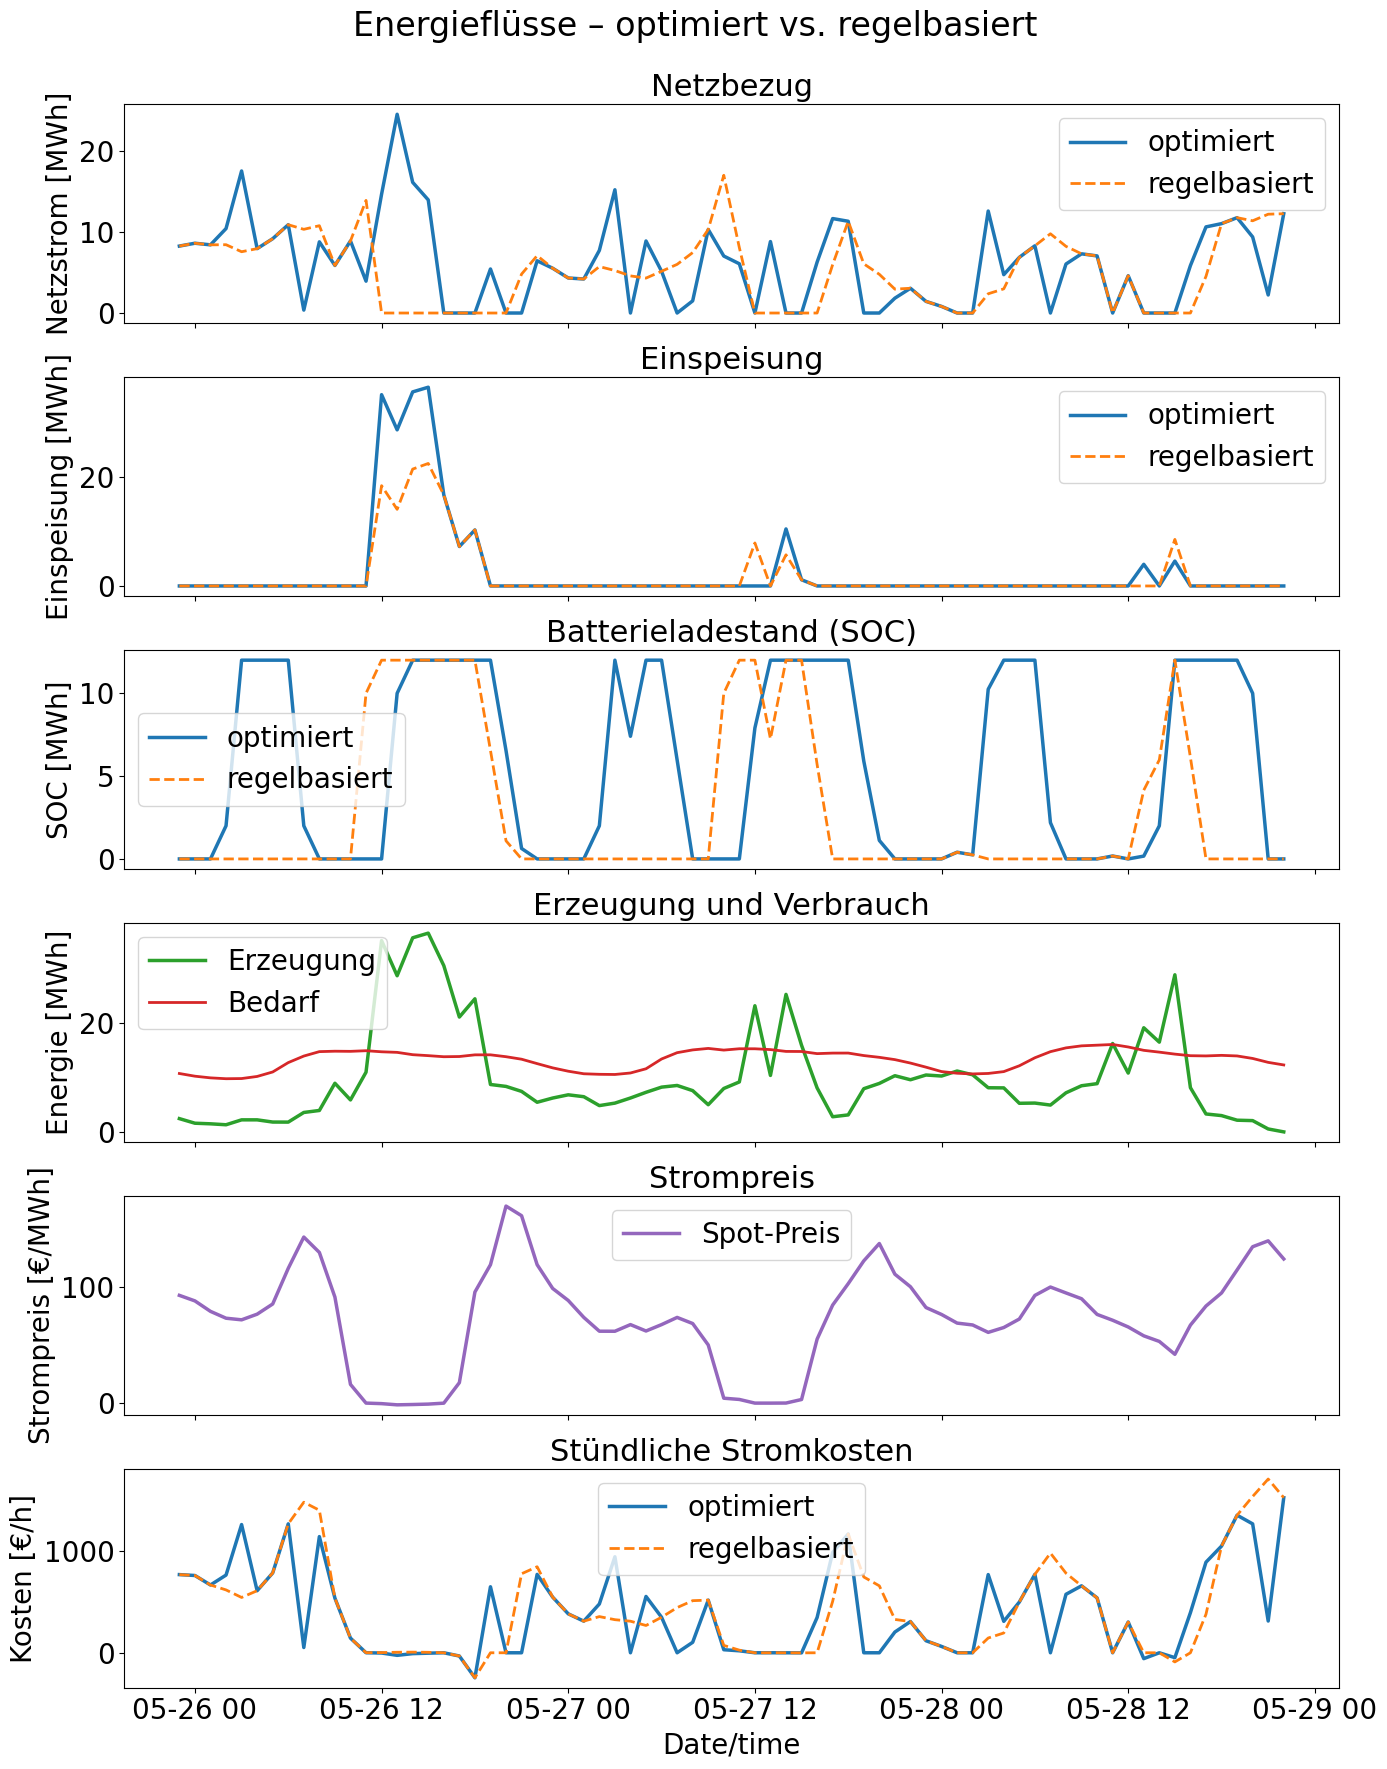

In [10]:
# Zeitspalten
result_df_opt["datetime"] = pd.to_datetime(result_df_opt["datetime"])
result_df_rule["datetime"] = pd.to_datetime(result_df_rule["datetime"])

# Kopien + Hilfsspalten
opt  = result_df_opt.copy()
rule = result_df_rule.copy()
for df in (opt, rule):
    df["grid_buy"]       = df["grid_to_load_MWh"] + df["grid_to_batt_MWh"]
    df["battery_state"]  = df["SOC_MWh"]
    df["grid_feed_in"]   = df["ee_export_MWh"]
    # stündliche Kosten (€/h)
    df["hourly_cost_EUR"] = (
        (df["grid_to_load_MWh"] + df["grid_to_batt_MWh"]) * df["spotprice_EUR_per_MWh"]
        - export_factor * df["ee_export_MWh"] * df["spotprice_EUR_per_MWh"]
    )

# Zeitfenster
start_time = opt["datetime"].min() + pd.Timedelta(days=1)
end_time   = start_time + pd.Timedelta(days=3)
opt  = opt[(opt["datetime"] >= start_time) & (opt["datetime"] < end_time)]
rule = rule[(rule["datetime"] >= start_time) & (rule["datetime"] < end_time)]

# Styles
label_fontsize = 20
tick_fontsize  = 20
legend_fontsize= 20
title_fontsize = 22
c_opt  = "tab:blue"
c_rule = "tab:orange"
c_gen  = "tab:green"
c_dem  = "tab:red"
c_prc  = "tab:purple"

# Plot (jetzt 6 Panels inkl. Kosten)
fig, axs = plt.subplots(6, 1, figsize=(14, 18), sharex=True)
fig.suptitle("Energieflüsse – optimiert vs. regelbasiert", fontsize=title_fontsize+2)

# 1) Netzbezug
axs[0].set_title("Netzbezug", fontsize=title_fontsize)
axs[0].plot(opt["datetime"],  opt["grid_buy"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[0].plot(rule["datetime"], rule["grid_buy"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[0].set_ylabel("Netzstrom [MWh]", fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# 2) Einspeisung
axs[1].set_title("Einspeisung", fontsize=title_fontsize)
axs[1].plot(opt["datetime"],  opt["grid_feed_in"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[1].plot(rule["datetime"], rule["grid_feed_in"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[1].set_ylabel("Einspeisung [MWh]", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# 3) Batteriezustand
axs[2].set_title("Batterieladestand (SOC)", fontsize=title_fontsize)
axs[2].plot(opt["datetime"],  opt["battery_state"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[2].plot(rule["datetime"], rule["battery_state"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[2].set_ylabel("SOC [MWh]", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

# 4) Erzeugung und Verbrauch
axs[3].set_title("Erzeugung und Verbrauch", fontsize=title_fontsize)
axs[3].plot(opt["datetime"], opt["EE_total_MWh"], label="Erzeugung", color=c_gen, linewidth=2.5)
axs[3].plot(opt["datetime"], opt["demand_MWh"],     label="Bedarf",    color=c_dem, linewidth=2)
axs[3].set_ylabel("Energie [MWh]", fontsize=label_fontsize)
axs[3].legend(fontsize=legend_fontsize)
axs[3].tick_params(axis='both', labelsize=tick_fontsize)

# 5) Strompreis
axs[4].set_title("Strompreis", fontsize=title_fontsize)
axs[4].plot(opt["datetime"], opt["spotprice_EUR_per_MWh"], label="Spot-Preis", color=c_prc, linewidth=2.5)
axs[4].set_ylabel("Strompreis [€/MWh]", fontsize=label_fontsize)
axs[4].legend(fontsize=legend_fontsize)
axs[4].tick_params(axis='both', labelsize=tick_fontsize)

# 6) Stündliche Stromkosten
axs[5].set_title("Stündliche Stromkosten", fontsize=title_fontsize)
axs[5].plot(opt["datetime"],  opt["hourly_cost_EUR"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[5].plot(rule["datetime"], rule["hourly_cost_EUR"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[5].set_ylabel("Kosten [€/h]", fontsize=label_fontsize)
axs[5].legend(fontsize=legend_fontsize)
axs[5].tick_params(axis='both', labelsize=tick_fontsize)

plt.xlabel("Date/time", fontsize=label_fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
